In [2]:
Tweet(s)

Spark's randomSplit function can produce nondeterministic outputs, and what do do about it
=====================

We noticed an odd case of nondeterminism in Spark’s randomSplit function, which is often used to generate test/train data splits for Machine Learning training scripts. There are other posts, notably [this one](https://medium.com/udemy-engineering/pyspark-under-the-hood-randomsplit-and-sample-inconsistencies-examined-7c6ec62644bc) that diagnose the problem, but there are a few details to spell out. I also want to suggest an alternative to randomSplit that will guarantee determinism.

The Problem
-----------

If you want to split a data set 80/20 in Spark, you call `df.randomSplit([0.80, 0.20], seed)` where seed is some integer used to reseed the random number generator. Reseeding a generator is a common way to force determinism. But in this case it doesn’t work! In some cases (we’ll identify exactly which cases below), randomSplit will:

* Leave some rows out of either split
* Duplicate other rows into both splits
* On two separate runs on the same data with the same seed, assign data differently.

This feels like a bit of a bait and switch. I feel like any function that accepts a seed is advertising that it should be deterministic: otherwise why bother with the seed at all?

Luckily, there is a way to force randomSplit to be deterministic, and it’s listed in [several](https://medium.com/udemy-engineering/pyspark-under-the-hood-randomsplit-and-sample-inconsistencies-examined-7c6ec62644bc) [places](https://issues.apache.org/jira/browse/SPARK-12590) [online](https://docs.microsoft.com/en-us/azure/databricks/kb/data/random-split-behavior). The trick is to cache the dataframe before invoking randomSplit. If by some miracle this page SEOs high enough that you are hunting for a hint on nondeterministic randomSplit (randomSplit gives different results. pyspark randomSplit different results. err… sorry) then that’s it. Throw in a `df.cache().randomSplit`. Have a nice afternoon! 

But then I tried to explain what was going on to a colleague, and after we looked at the source code, it turned out it could be hard to figure out exactly when your code will be nondeterministic. I’ll explain what we found. I’m also going to suggest a **different way to randomly partition** that will definitely be deterministic no matter what.

Pseudorandomization: A Reminder
-----------

Just as a quick reminder, the way computers produce "random" numbers is actually pseudorandom: they start with some number then iterate in a complicated but deterministic way to produce a stream of numbers that are uncorrelated with each other. In the example below, we assign random numbers to some names, and we show that we can do this repeatably


In [3]:
import numpy as np

def assign_random(names, seed):
    np.random.seed(seed)
    return [(name, np.random.random()) for name in names]

names = ['alice', 'bob', 'tom', 'kat']

print(f"Random assignments with seed 1")
print(assign_random(names, seed=1))

print(f"Random assignments with seed 2")
print(assign_random(names, seed=2))

print(f"Random assignments with seed 1")
print(assign_random(names, seed=1))


Random assignments with seed 1
[('alice', 0.417022004702574), ('bob', 0.7203244934421581), ('tom', 0.00011437481734488664), ('kat', 0.30233257263183977)]
Random assignments with seed 2
[('alice', 0.43599490214200376), ('bob', 0.025926231827891333), ('tom', 0.5496624778787091), ('kat', 0.4353223926182769)]
Random assignments with seed 1
[('alice', 0.417022004702574), ('bob', 0.7203244934421581), ('tom', 0.00011437481734488664), ('kat', 0.30233257263183977)]


If we shuffle the names, we get different results even if we keep the seed.

In [4]:
shuffled_names = list(names)
np.random.shuffle(shuffled_names)
print(f"Random assignments with seed 1")
print(assign_random(names, seed=1))
print("Results with shuffled names")
print(assign_random(shuffled_names, seed=1))


Random assignments with seed 1
[('alice', 0.417022004702574), ('bob', 0.7203244934421581), ('tom', 0.00011437481734488664), ('kat', 0.30233257263183977)]
Results with shuffled names
[('bob', 0.417022004702574), ('tom', 0.7203244934421581), ('alice', 0.00011437481734488664), ('kat', 0.30233257263183977)]


Note that the *numbers* are the same, but they apply to different names.

So, the way to make a deterministic algorithm with a random number generator is to:

1. Set the seed the same way.
1. Invoke the random number generator the exact same number or times and use the sequence in the exact same way.


Another Reminder: Spark DataFrame definition vs execution
----------------------------------------------

Spark makes a distinction between *defining* what to do and *executing* the defined compute. Some expressions on DataFrames are transformations that convert one DataFrame to a new DataFrame while others are actions that execute a sequence of transformations. There are many sources talking about this distinction online, but the [original paper](https://www2.eecs.berkeley.edu/Pubs/TechRpts/2011/EECS-2011-82.pdf) on Spark is still a really great intro. (Aside: the paper talks about Resilient Distributed Datasets, which are a foundational element that DataFrames use).

If you’ve worked in Spark long at all, you’ve seen this phenomenon. I can execute the following commands in a REPL and they succeed almost immediately no matter how big the data really is:

`
df = spark.read.parquet("/some/parquet/file/pattern*.parquet")
df = df.filter(df['amount'] > 4000).filter(df['month'] != 'jan').show()
df2 = spark.read.parquet("/someother/parquet/file/pattern*.parquet")
df3 = df.join(df2)
`

That’s because all I’ve done so far is define a set of computations. You can see the plan by trying

`df3.explain()`

But when we execute something like `df3.count()`, we issue an action. The set of transformations that create `df3` execute on Spark workers, and it can take much longer to execute the statement because it blocks on the actual Spark action finishing.

In a normal python script, if you trace the program on a white board, you can basically track the system state line by line. But in a pyspark script, it’s much harder to trace when the "real" work (the actions) take place, or even when and how often they take place.


randomSplit([0.8, 0.2], seed) creates two DataFrames, and each results in an action
------------------

Ok, so now it’s time to look at the randomSplit function. The [actual code](https://github.com/apache/spark/blob/master/sql/core/src/main/scala/org/apache/spark/sql/Dataset.scala#L2316) is below:

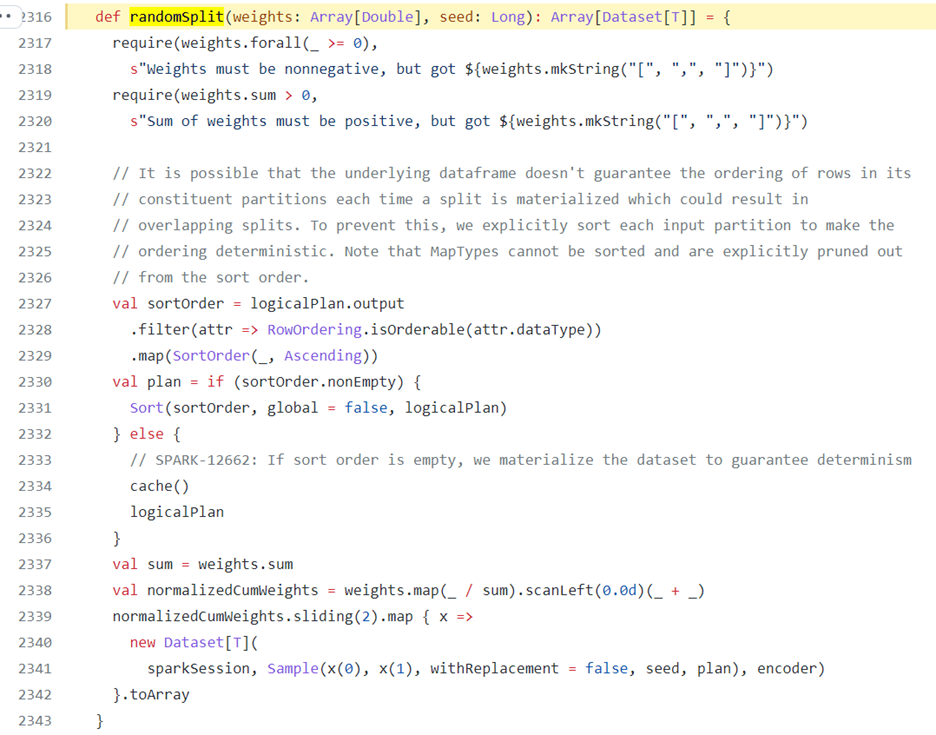

This is what it does:

* Sort the data within each partition. This ensures that within a Spark partition, the random number generator in Sample will execute the same number of times and will use the random numbers in the same exact way.
* Normalize the weights. 
* Issue a series of calls to Sample with different sliding windows and with the same seed. Those calls are totally independent, and each call returns a Dataframe. 
* Return a list of DataFrames: one per sample partition.

Sample is a transformation: it adds to the DAG of transformations but doesn’t result in an action. In our example of an 80/20 split, the first call to Sample will use a random generator to assign a value between 0 and 1 to every row, and it will keep rows where the random value is `<0.8`. The second call will assign new random values to every row and keep rows where the random value is `>0.8`. This works if and only if the random reassignment is exactly the same in both calls to Sample. 

Each of the 2 DataFrames (one with 80% of data and one with 20%) corresponds to a set of transformations. They share the set of steps up to the sample transformation, but those shared steps will execute independently for each random split. This could extend all the way back to data reading, so data would literally be read from disk independently for the 80% sample and the 20% sample. Any other work that happens in the DataFrame before Sample will also run twice.

This all works just fine assuming *every step in the upstream DAG deterministically maps data to partitions*! If everything is deterministic upstream, then all data maps to the same partition every time the script runs, and that data is sorted the same way in randomSplit every time, and the random numbers generated use the same seed and used on the same data row every time. But if something upstream changes the mapping of data to partitions then some rows will end up on different partitions in the execution for the 80% sample than they end up in the 20% sample. To summarize:

* If a non-deterministic process maps data to partitions, then the non-deterministic process could run independently per partition.
* If the independent, non-deterministic transformation changes something that Spark uses to partition data, then some rows may map to partitions differently in each DAG execution.
* That data is assigned different random numbers in the 80% sample and 20% sample because the random numbers in Sample are used differently in the two samples. In fact, likely nearly all data gets different random numbers because any change to partitioning impacts data that is sorted.

What could cause the DataFrame input to randomSplit to be non-deterministic? Here are a few samples:

* Changing data. If your data changes between reads, the two frames could start with different data. This could happen if you are, say, reading from a stream with frequent appends. The extra rows from the second action would end up somewhere. 
* Some UDFs (User Defined Functions) can be nondeterministic. A classic example would be a function that generates a UUID for every row, especially if you later use that field as a primary key.

There used to be a much more nefarious problem in [Shuffle](https://spark.apache.org/docs/latest/rdd-programming-guide.html#shuffle-operations) when used in `df.partition(int)`. Spark did a round robin partitioning, which meant rows were distributed across partitions in a way that depended on the order of data in the original partition. By now, you should see a problem with that approach! In fact, someone filed a [bug](https://issues.apache.org/jira/browse/SPARK-23207) pointing out the same sort of nondeterministic behavior we saw in randomSplit, and it was fixed. The [source](https://github.com/apache/spark/blob/branch-2.4/sql/core/src/main/scala/org/apache/spark/sql/execution/exchange/ShuffleExchangeExec.scala#L265) for round robin shuffling now explicitly sorts to ensure rows are handled in a deterministic order.


A Few Workarounds
--------------

There are really two options, and they are [documented elsewhere](https://docs.microsoft.com/en-us/azure/databricks/kb/data/random-split-behavior) in more detail. They boil down to:

1. Force the upstream DAG to only run once. This is what cache does: it persists the DataFrame to memory or disk. Subsequent reads hit the cache, so `someNonDeterministicDataFrame.cache().randomSplit` forces the DAG creating `someNonDeterministicDataFrame` to run once, saves results in cache, then forces all samples in randomSplit to read from the cache. The cache is deterministic by definition: it’s a fixed data set. 

1. Do something that deterministically forces data to partitions. Do this after the nondeterministic transformation, and be careful not to partition on something that is nondeterministic (like a guid you build in a UDF)!


Both workaround options require that you **think globally** to **act locally**. That breaks the encapsulation that is at the core of software engineering! You are left to either understand every step upstream in the DAG (likely by using explain function) and hoping that doesn’t change or adding potentially expensive extra computation to guard against changes. Both of these options effectively require global knowledge and global change knowledge! For example, my team at Microsoft intentionally separates the problem of reading data from disk and producing DataFrames from the actual Machine Learning training and inference steps. We don’t want you to think globally!

An Alternative Fix: Deterministic by Design Shuffle
----------------------

`randomSplit` relies on *DataFrame structure* to produce deterministic results: consistent data-to-partition mapping and consistent ordering within partition (enforced in the method). Another approach is to deterministically use the *data values* to map to partitions. This is an approach that is commonly used in AB test initialization (I described it [here](https://github.com/guyrt/guyrt.github.com/blob/master/notebooks/RandomizingUsers.ipynb)) that has a few interesting properties:

* The same input always maps to the same sample.
* You can use a subset of columns to consistently hash all data that matches on the subset to same sample. For instance, you could map all data from a userId to the same random split.
* The algorithm is stateless: this is important for scale in AB testing but for our purposes it makes implementation easier.

The basic idea for a row is:
1. Concatenate any columns you want to sample on into a new column.
1. Add a salt to the new column (we’ll use seed), which allows us to produce different partitions at different times.
1. Hash the column.
1. Compute the modulus of the hash using some large modulus number (say 1000) \[0\]
1. Pick a set of modulus outputs for each split. For an 80/20 split, moduli 0-799 is the 80% split and 800-999 is the 20% split.

In pyspark:


In [5]:
from pyspark.sql.functions import col, hash, lit
from itertools import tee

def pairwise(iterable):
    # scala has this as window function.
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def cumsum(l):
    new_list = []
    j = 0
    for i in l:
        j += i
        new_list.append(j)
    return new_list


def randomSplit(df, weights, seed, columns_to_include=None, modulus=10000, hash_name="__hash", salt_name="__salt"):
    # Caution! This implementation will map identical rows identically.
    if not columns_to_include:
        columns_to_include = df.columns
    columns_to_include += [salt_name]
    weight_sum = sum(weights)
    normalized_weights = [0.0] + [w/weight_sum * modulus for w in weights]
    normalized_weights = cumsum(normalized_weights)
    
    # find the breaks in modulus range. Note that the range for mod is (-modulus, modulus)
    cutoffs = [w * 2 - modulus for w in normalized_weights]
    
    internal_df = df.withColumn(salt_name, lit(seed))
    internal_df = internal_df.withColumn(hash_name, hash(*columns_to_include) % modulus)
    
    return_dfs = [
         internal_df.filter(col(hash_name) >= low).filter(col(hash_name) < high).drop(hash_name, salt_name) 
            for (low, high) in pairwise(cutoffs)
    ]
    return return_dfs


Special thanks to [Kidus Asfaw](https://kidusasfaw.github.io/) for initially bringing this problem and some of the links to my attention. If you want to join me and Kidus and work on Machine Learning and occasional Spark headscratchers, feel free to reach out at riguy (at) microsoft.com!

In [1]:
# I ran this first so I could embed that tweet at the top.

class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

s = ("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">&quot;Computers are deterministic&quot;, asserts some cryptobro trying to argue that code should be law.<br><br>Oh you sweet, sweet summer child.</p>&mdash; Mike Conley @mconley@mastodon.social (@mike_conley) <a href="https://twitter.com/mike_conley/status/1486735868182384643?ref_src=twsrc%5Etfw">January 27, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")

In [6]:
# this is just code to test my method! 

import json
import random
words = json.load(open("../data/words.json", 'r'))

data = [(w, max(1, min(6, int(random.gauss(4, 1))))) for w in words for guess in range(random.randint(1, 9))]


In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [8]:
df = spark.createDataFrame(data, ["word", "numGuesses"])

In [9]:
df.printSchema()

root
 |-- word: string (nullable = true)
 |-- numGuesses: long (nullable = true)



In [10]:
outcome = randomSplit(df, [.8, .2], seed=1)

In [11]:
outcome[0].explain()

== Physical Plan ==
*(1) Filter ((cast((hash(word#0, numGuesses#1L, 1, 42) % 10000) as double) >= -10000.0) && (cast((hash(word#0, numGuesses#1L, 1, 42) % 10000) as double) < 6000.0))
+- Scan ExistingRDD[word#0,numGuesses#1L]


In [12]:
outcome[0].count()

9210

In [13]:
outcome[1].count()

2305

In [14]:
df.count()

11515

In [15]:
outcome_by_word = randomSplit(df, [.8, .2], seed=1, columns_to_include=['word'])